# Формирование датасета
Для обучения модели нужно сформировать датасет из ~10000 фотографий из оригинального датасета CelebA. Предварительно собрал и загрузил сам датасет CelebA на Kaggle (в том что был указан в ноутбуке с заданием не было файла identity файла(пригодиться для фильтрации)) и использовал его в качестве Input-а для ноутбука.

In [36]:
# Импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.patches as patches
import shutil
from pathlib import Path
import zipfile

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Загрузка данных
Добавил чтение датасета из Input-а, если ноутбук исполняется на Kaggle. И есть отдельная ячейка для загрузки и чтения датасета из Google Drive([ссылка](https://drive.google.com/file/d/1wSYBfJmmazbbj9p3gpe1mA9_gJpCWn1j/view?usp=sharing))

In [37]:
BASE_DIR = '/kaggle/input/celeba-simplified'

IDENTITY_FILE = os.path.join(BASE_DIR, 'annotations/identity_CelebA.txt')
ATTR_FILE = os.path.join(BASE_DIR, 'annotations/list_attr_celeba.txt')
BBOX_FILE = os.path.join(BASE_DIR, 'annotations/list_bbox_celeba.txt')
LANDMARKS_FILE = os.path.join(BASE_DIR, 'annotations/list_landmarks_celeba.txt')
# LANDMARKS_ALIGNED_FILE = os.path.join(BASE_DIR, 'annotations/list_landmarks_align_celeba.txt') # Этот файл нам не нужен, ну он тут есть ;)
IMAGES_DIR = os.path.join(BASE_DIR, 'images')

print("Проверка наличия файлов:")
for name, path in [
    ('Identity', IDENTITY_FILE),
    ('Attributes', ATTR_FILE),
    ('BBox', BBOX_FILE),
    ('Landmarks', LANDMARKS_FILE),
    ('Images dir', IMAGES_DIR)
]:
    exists = "OK" if os.path.exists(path) else "NOT FOUND"
    print(f"{exists} {name}: {path}")

Проверка наличия файлов:
OK Identity: /kaggle/input/celeba-simplified/annotations/identity_CelebA.txt
OK Attributes: /kaggle/input/celeba-simplified/annotations/list_attr_celeba.txt
OK BBox: /kaggle/input/celeba-simplified/annotations/list_bbox_celeba.txt
OK Landmarks: /kaggle/input/celeba-simplified/annotations/list_landmarks_celeba.txt
OK Images dir: /kaggle/input/celeba-simplified/images


In [38]:
# TODO добавить загрузку датасета из Google Drive

In [39]:
print("Загрузка identity_CelebA.txt...")
df_identity = pd.read_csv(IDENTITY_FILE, sep=' ', header=None, 
                          names=['image_id', 'person_id'])
print(f"Загружено: {len(df_identity):,} записей")
print(f"Уникальных персон: {df_identity['person_id'].nunique():,}")

df_identity.set_index('image_id', inplace=True)
df_identity.info(verbose=True)

Загрузка identity_CelebA.txt...
Загружено: 202,599 записей
Уникальных персон: 10,177
<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   person_id  202599 non-null  int64
dtypes: int64(1)
memory usage: 3.1+ MB


In [40]:
print("Загрузка list_attr_celeba.txt...")

with open(ATTR_FILE, 'r') as f:
    num_images = int(f.readline().strip())
    column_names = f.readline().strip().split()
    
df_attr = pd.read_csv(ATTR_FILE, sep=r'\s+', skiprows=2)

column_names = ['image_id'] + column_names
df_attr.columns = column_names

# Конвертируем -1/1 в 0/1 для удобства
attr_columns = [col for col in df_attr.columns if col != 'image_id']
for col in attr_columns:
    df_attr[col] = (df_attr[col] == 1).astype(int)

print(f"Загружено: {len(df_attr):,} записей")
print(f"Количество атрибутов: {len(attr_columns)}")

df_attr.set_index('image_id', inplace=True)
df_attr.info(verbose=True)

Загрузка list_attr_celeba.txt...
Загружено: 202,598 записей
Количество атрибутов: 40
<class 'pandas.core.frame.DataFrame'>
Index: 202598 entries, 000002.jpg to 202599.jpg
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   5_o_Clock_Shadow     202598 non-null  int64
 1   Arched_Eyebrows      202598 non-null  int64
 2   Attractive           202598 non-null  int64
 3   Bags_Under_Eyes      202598 non-null  int64
 4   Bald                 202598 non-null  int64
 5   Bangs                202598 non-null  int64
 6   Big_Lips             202598 non-null  int64
 7   Big_Nose             202598 non-null  int64
 8   Black_Hair           202598 non-null  int64
 9   Blond_Hair           202598 non-null  int64
 10  Blurry               202598 non-null  int64
 11  Brown_Hair           202598 non-null  int64
 12  Bushy_Eyebrows       202598 non-null  int64
 13  Chubby               202598 non-null  int64
 14  Double_

In [41]:
print("Загрузка list_bbox_celeba.txt...")
with open(BBOX_FILE, 'r') as f:
    num_images = int(f.readline().strip())
    
df_bbox = pd.read_csv(BBOX_FILE, sep=r'\s+', skiprows=1)
df_bbox.columns = ['image_id', 'x_1', 'y_1', 'width', 'height']
df_bbox['area'] = df_bbox['width'] * df_bbox['height']
print(f"Загружено: {len(df_bbox):,} записей")

df_bbox.set_index(df_bbox.columns[0], inplace=True)
df_bbox.info(verbose=True)

Загрузка list_bbox_celeba.txt...
Загружено: 202,599 записей
<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   x_1     202599 non-null  int64
 1   y_1     202599 non-null  int64
 2   width   202599 non-null  int64
 3   height  202599 non-null  int64
 4   area    202599 non-null  int64
dtypes: int64(5)
memory usage: 9.3+ MB


In [42]:
print("Загрузка list_landmarks_celeba.txt...")    
df_landmarks = pd.read_csv(LANDMARKS_FILE, sep=r'\s+', skiprows=2, header=None)

# Задаем имена колонок вручную
column_names = ['image_id', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y', 
                'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 
                'rightmouth_x', 'rightmouth_y']
df_landmarks.columns = column_names

# Устанавливаем image_id как индекс
df_landmarks.set_index('image_id', inplace=True)

# Вычисляем расстояние между глазами (для анализа разнообразия поз)
df_landmarks['eye_distance'] = np.sqrt(
    (df_landmarks['righteye_x'] - df_landmarks['lefteye_x'])**2 + 
    (df_landmarks['righteye_y'] - df_landmarks['lefteye_y'])**2
)

print(f"Загружено: {len(df_landmarks):,} записей")

df_landmarks.info(verbose=True)

Загрузка list_landmarks_celeba.txt...
Загружено: 202,599 записей
<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   lefteye_x     202599 non-null  int64  
 1   lefteye_y     202599 non-null  int64  
 2   righteye_x    202599 non-null  int64  
 3   righteye_y    202599 non-null  int64  
 4   nose_x        202599 non-null  int64  
 5   nose_y        202599 non-null  int64  
 6   leftmouth_x   202599 non-null  int64  
 7   leftmouth_y   202599 non-null  int64  
 8   rightmouth_x  202599 non-null  int64  
 9   rightmouth_y  202599 non-null  int64  
 10  eye_distance  202599 non-null  float64
dtypes: float64(1), int64(10)
memory usage: 18.5+ MB


## Анализ датасета
Проанализировал данные:
- сколько в среднем количество фото для одной персоны;
- посчитал распределение отрибутов;
- нашёл интересные коррелляции между атрибутами.

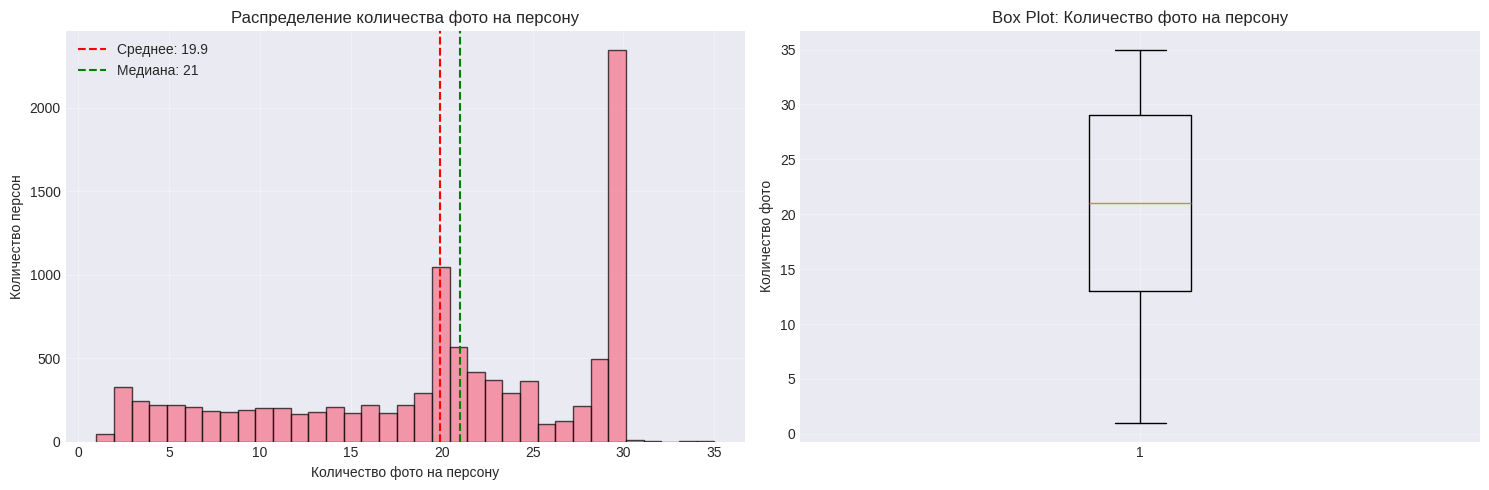

In [43]:
# Подсчитываем количество фото для каждой персоны
person_counts = df_identity['person_id'].value_counts()

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(person_counts, bins=35, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Количество фото на персону')
axes[0].set_ylabel('Количество персон')
axes[0].set_title('Распределение количества фото на персону')
axes[0].axvline(person_counts.mean(), color='red', linestyle='--', 
                label=f'Среднее: {person_counts.mean():.1f}')
axes[0].axvline(person_counts.median(), color='green', linestyle='--', 
                label=f'Медиана: {person_counts.median():.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].boxplot(person_counts, vert=True)
axes[1].set_ylabel('Количество фото')
axes[1].set_title('Box Plot: Количество фото на персону')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Общая статистика по персонам:
- Всего уникальных персон: 10,177
- Среднее фото на персону: 19.9
- Медиана фото на персону: 21
- Минимум фото: 1
- Максимум фото: 35
- Стандартное отклонение: 8.9

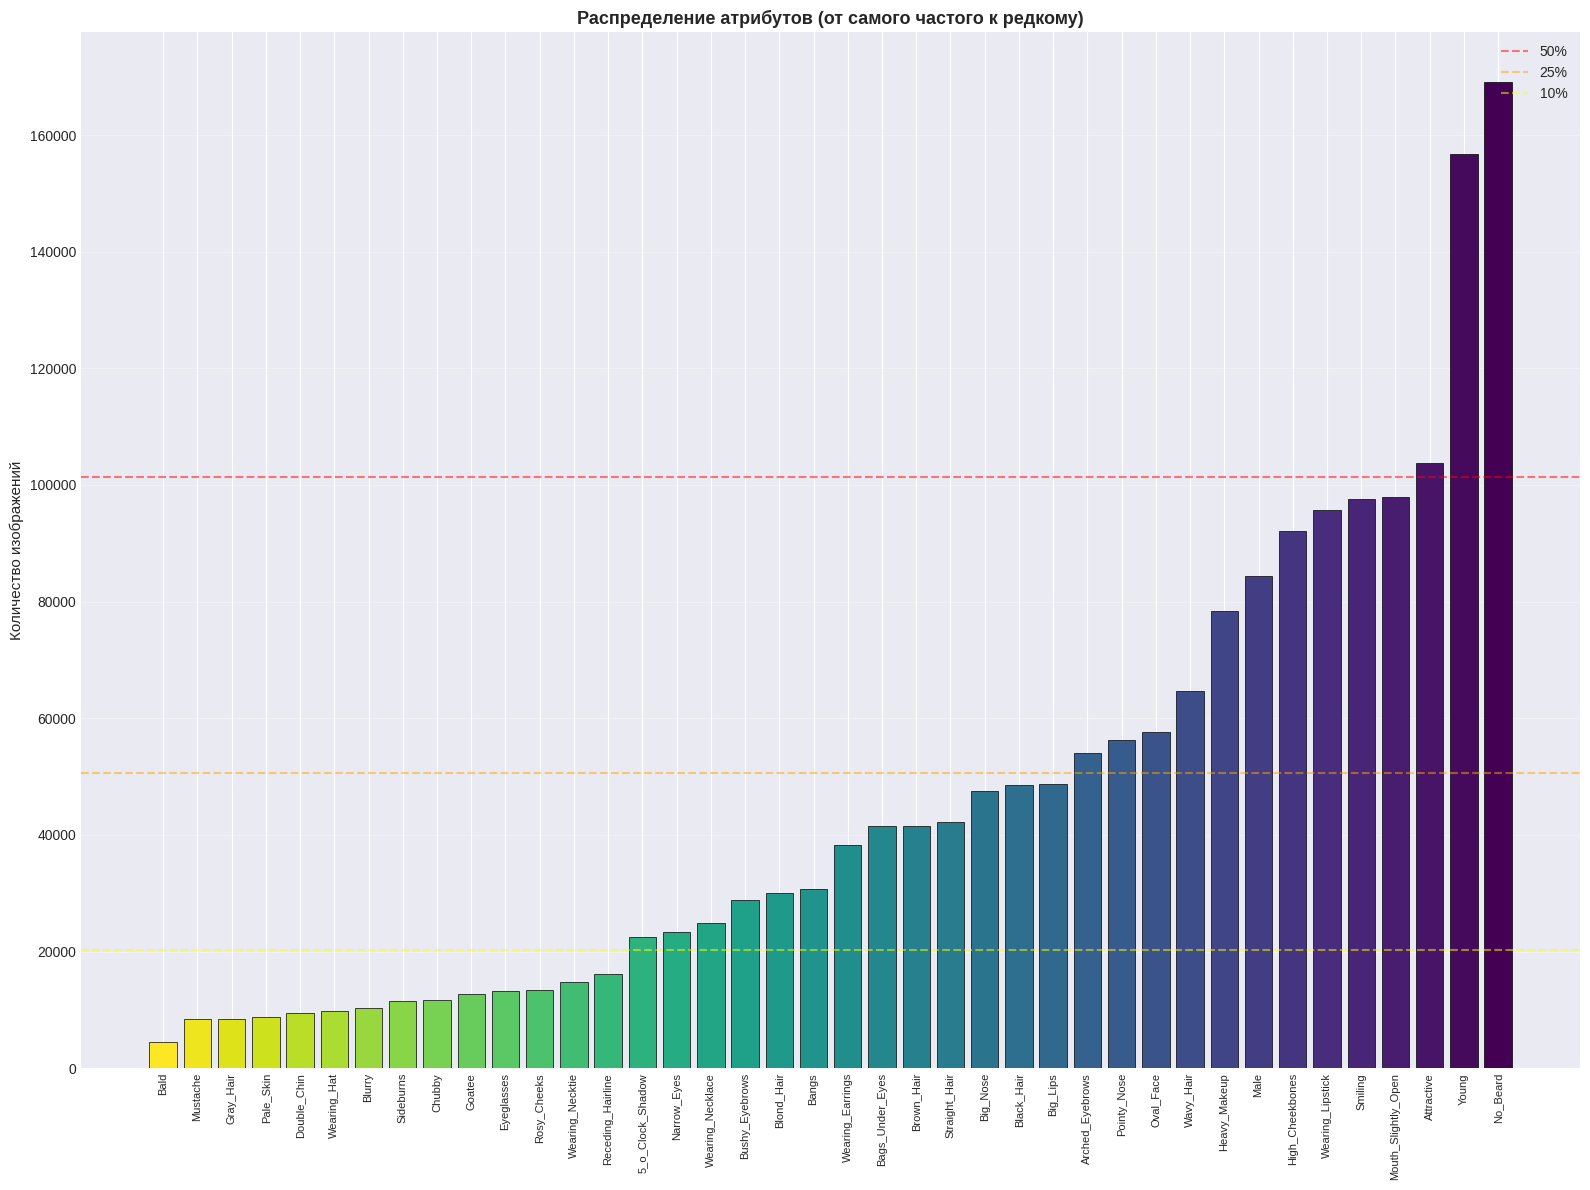

In [44]:
# Подсчет частоты каждого атрибута
attr_frequencies = df_attr[attr_columns].sum().sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(attr_frequencies)))

fig, axes = plt.subplots(figsize=(16, 12))

axes.bar(range(len(attr_frequencies)), attr_frequencies.values, 
            color=colors[::-1], edgecolor='black', linewidth=0.5)
axes.set_xticks(range(len(attr_frequencies)))
axes.set_xticklabels(attr_frequencies.index, rotation=90, fontsize=8)
axes.set_ylabel('Количество изображений', fontsize=11)
axes.set_title('Распределение атрибутов (от самого частого к редкому)', fontsize=13, fontweight='bold')
axes.grid(True, alpha=0.3, axis='y')

axes.axhline(len(df_attr) * 0.5, color='red', linestyle='--', alpha=0.5, label='50%')
axes.axhline(len(df_attr) * 0.25, color='orange', linestyle='--', alpha=0.5, label='25%')
axes.axhline(len(df_attr) * 0.1, color='yellow', linestyle='--', alpha=0.5, label='10%')
axes.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Общая статистика по атрибутам:
- 84,434 мужчин (41.7%)
- 118,164 женщин (58.3%)
- 10,312 размытых изображений (5.1%) - нужно исключить
- 13,193 с очками (6.5%) - редкий атрибут(стоит учесть)

In [62]:
# Проверим корреляцию между несколькими атрибутами

interesting_pairs = [
    ('Male', 'Heavy_Makeup'),
    ('Male', 'Wearing_Lipstick'),
    ('Young', 'Bald'),
    ('Smiling', 'Mouth_Slightly_Open'),
    ('Eyeglasses', 'Wearing_Hat'),
    ('Eyeglasses', 'Young'),
    ('Black_Hair', 'Blond_Hair'),
    ('Black_Hair', 'Brown_Hair'),
    ('Attractive', 'Heavy_Makeup'),
]

print("\n\nВзаимная встречаемость атрибутов:")
for attr1, attr2 in interesting_pairs:
    # Проверяем наличие атрибутов
    if attr1 not in df_attr.columns or attr2 not in df_attr.columns:
        print(f"\n⚠ {attr1} или {attr2} отсутствует в данных, пропускаем...")
        continue
        
    both = ((df_attr[attr1] == 1) & (df_attr[attr2] == 1)).sum()
    only_1 = ((df_attr[attr1] == 1) & (df_attr[attr2] == 0)).sum()
    only_2 = ((df_attr[attr1] == 0) & (df_attr[attr2] == 1)).sum()
    neither = ((df_attr[attr1] == 0) & (df_attr[attr2] == 0)).sum()
    
    print(f"\n{attr1} vs {attr2}:")
    print(f"  Оба атрибута:                {both:7,} ({both/len(df_attr)*100:5.1f}%)")
    print(f"  Только {attr1:20s}: {only_1:7,} ({only_1/len(df_attr)*100:5.1f}%)")
    print(f"  Только {attr2:20s}: {only_2:7,} ({only_2/len(df_attr)*100:5.1f}%)")
    print(f"  Ни один:                     {neither:7,} ({neither/len(df_attr)*100:5.1f}%)")



Взаимная встречаемость атрибутов:

Male vs Heavy_Makeup:
  Оба атрибута:                    234 (  0.1%)
  Только Male                :  84,200 ( 41.6%)
  Только Heavy_Makeup        :  78,155 ( 38.6%)
  Ни один:                      40,009 ( 19.7%)

Male vs Wearing_Lipstick:
  Оба атрибута:                    523 (  0.3%)
  Только Male                :  83,911 ( 41.4%)
  Только Wearing_Lipstick    :  95,191 ( 47.0%)
  Ни один:                      22,973 ( 11.3%)

Young vs Bald:
  Оба атрибута:                  1,053 (  0.5%)
  Только Young               : 155,680 ( 76.8%)
  Только Bald                :   3,494 (  1.7%)
  Ни один:                      42,371 ( 20.9%)

Smiling vs Mouth_Slightly_Open:
  Оба атрибута:                 74,350 ( 36.7%)
  Только Smiling             :  23,318 ( 11.5%)
  Только Mouth_Slightly_Open :  23,591 ( 11.6%)
  Ни один:                      81,339 ( 40.1%)

Eyeglasses vs Wearing_Hat:
  Оба атрибута:                  1,401 (  0.7%)
  Только Eyeglasses  

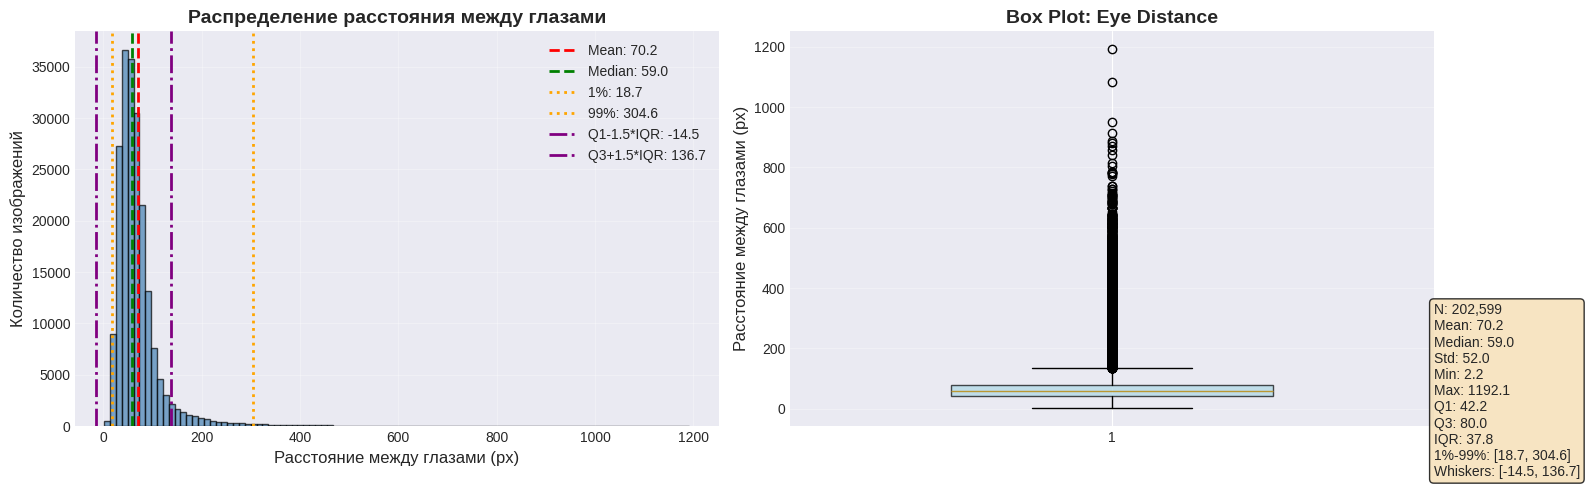

In [46]:
# Анализ распределения расстояния между глазами
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

eye_distances = df_landmarks['eye_distance']

# Гистограмма с box plot
axes[0].hist(eye_distances, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Расстояние между глазами (px)', fontsize=12)
axes[0].set_ylabel('Количество изображений', fontsize=12)
axes[0].set_title('Распределение расстояния между глазами', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Добавляем статистику на график
mean_val = eye_distances.mean()
median_val = eye_distances.median()
std_val = eye_distances.std()
q1 = eye_distances.quantile(0.25)
q3 = eye_distances.quantile(0.75)
iqr = q3 - q1
lower_whisker = q1 - 1.5 * iqr
upper_whisker = q3 + 1.5 * iqr
percentile_1 = eye_distances.quantile(0.01)
percentile_99 = eye_distances.quantile(0.99)

axes[0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
axes[0].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
axes[0].axvline(percentile_1, color='orange', linestyle=':', linewidth=2, label=f'1%: {percentile_1:.1f}')
axes[0].axvline(percentile_99, color='orange', linestyle=':', linewidth=2, label=f'99%: {percentile_99:.1f}')
axes[0].axvline(lower_whisker, color='purple', linestyle='-.', linewidth=2, label=f'Q1-1.5*IQR: {lower_whisker:.1f}')
axes[0].axvline(upper_whisker, color='purple', linestyle='-.', linewidth=2, label=f'Q3+1.5*IQR: {upper_whisker:.1f}')

axes[0].legend(loc='upper right', fontsize=10)

# Box plot
bp = axes[1].boxplot(eye_distances, vert=True, patch_artist=True, 
                     showfliers=True, widths=0.5)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_alpha(0.7)

axes[1].set_ylabel('Расстояние между глазами (px)', fontsize=12)
axes[1].set_title('Box Plot: Eye Distance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Добавляем текст со статистикой
stats_text = f'N: {len(eye_distances):,}\n'
stats_text += f'Mean: {mean_val:.1f}\n'
stats_text += f'Median: {median_val:.1f}\n'
stats_text += f'Std: {std_val:.1f}\n'
stats_text += f'Min: {eye_distances.min():.1f}\n'
stats_text += f'Max: {eye_distances.max():.1f}\n'
stats_text += f'Q1: {q1:.1f}\n'
stats_text += f'Q3: {q3:.1f}\n'
stats_text += f'IQR: {iqr:.1f}\n'
stats_text += f'1%-99%: [{percentile_1:.1f}, {percentile_99:.1f}]\n'
stats_text += f'Whiskers: [{lower_whisker:.1f}, {upper_whisker:.1f}]'

axes[1].text(1.5, eye_distances.median(), stats_text, fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            verticalalignment='center')

plt.tight_layout()
plt.show()

# Применяем выбранные границы (используем whiskers)
EYE_DIST_MIN = lower_whisker
EYE_DIST_MAX = upper_whisker

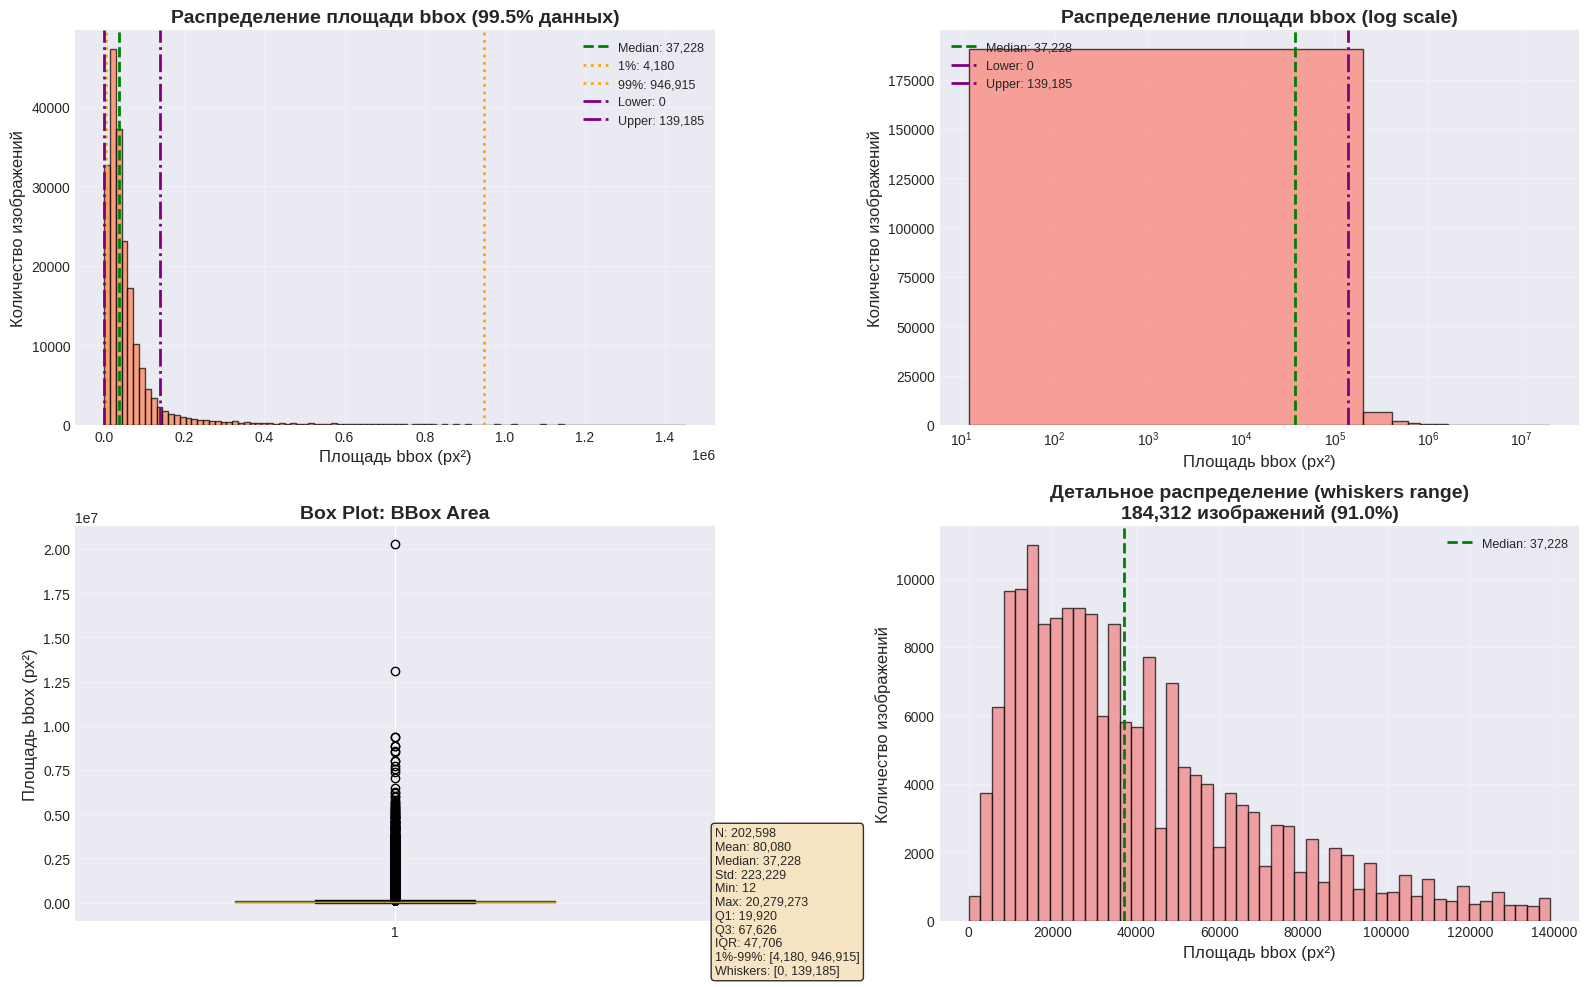

In [47]:
# Анализ распределения площади bbox
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

bbox_areas = df_bbox['area']

# Убираем экстремальные выбросы для лучшей визуализации
bbox_areas_clean = bbox_areas[bbox_areas > 0]  # Убираем нули

# 1. Гистограмма с нормальной шкалой (обрезанная)
percentile_995 = bbox_areas_clean.quantile(0.995)
bbox_areas_trimmed = bbox_areas_clean[bbox_areas_clean <= percentile_995]

axes[0, 0].hist(bbox_areas_trimmed, bins=100, edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].set_xlabel('Площадь bbox (px²)', fontsize=12)
axes[0, 0].set_ylabel('Количество изображений', fontsize=12)
axes[0, 0].set_title('Распределение площади bbox (99.5% данных)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Статистика
mean_val = bbox_areas_clean.mean()
median_val = bbox_areas_clean.median()
std_val = bbox_areas_clean.std()
q1 = bbox_areas_clean.quantile(0.25)
q3 = bbox_areas_clean.quantile(0.75)
iqr = q3 - q1
lower_whisker = max(0, q1 - 1.5 * iqr)
upper_whisker = q3 + 1.5 * iqr
percentile_1 = bbox_areas_clean.quantile(0.01)
percentile_99 = bbox_areas_clean.quantile(0.99)

axes[0, 0].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:,.0f}')
axes[0, 0].axvline(percentile_1, color='orange', linestyle=':', linewidth=2, label=f'1%: {percentile_1:,.0f}')
axes[0, 0].axvline(percentile_99, color='orange', linestyle=':', linewidth=2, label=f'99%: {percentile_99:,.0f}')
axes[0, 0].axvline(lower_whisker, color='purple', linestyle='-.', linewidth=2, label=f'Lower: {lower_whisker:,.0f}')
axes[0, 0].axvline(upper_whisker, color='purple', linestyle='-.', linewidth=2, label=f'Upper: {upper_whisker:,.0f}')
axes[0, 0].legend(loc='upper right', fontsize=9)

# 2. Гистограмма с логарифмической шкалой (все данные)
axes[0, 1].hist(bbox_areas_clean, bins=100, edgecolor='black', alpha=0.7, color='salmon')
axes[0, 1].set_xlabel('Площадь bbox (px²)', fontsize=12)
axes[0, 1].set_ylabel('Количество изображений', fontsize=12)
axes[0, 1].set_title('Распределение площади bbox (log scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:,.0f}')
axes[0, 1].axvline(lower_whisker, color='purple', linestyle='-.', linewidth=2, label=f'Lower: {lower_whisker:,.0f}')
axes[0, 1].axvline(upper_whisker, color='purple', linestyle='-.', linewidth=2, label=f'Upper: {upper_whisker:,.0f}')
axes[0, 1].legend(loc='upper left', fontsize=9)

# 3. Box plot
bp = axes[1, 0].boxplot(bbox_areas_clean, vert=True, patch_artist=True, 
                        showfliers=True, widths=0.5)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][0].set_alpha(0.7)

axes[1, 0].set_ylabel('Площадь bbox (px²)', fontsize=12)
axes[1, 0].set_title('Box Plot: BBox Area', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Статистика
stats_text = f'N: {len(bbox_areas_clean):,}\n'
stats_text += f'Mean: {mean_val:,.0f}\n'
stats_text += f'Median: {median_val:,.0f}\n'
stats_text += f'Std: {std_val:,.0f}\n'
stats_text += f'Min: {bbox_areas_clean.min():,.0f}\n'
stats_text += f'Max: {bbox_areas_clean.max():,.0f}\n'
stats_text += f'Q1: {q1:,.0f}\n'
stats_text += f'Q3: {q3:,.0f}\n'
stats_text += f'IQR: {iqr:,.0f}\n'
stats_text += f'1%-99%: [{percentile_1:,.0f}, {percentile_99:,.0f}]\n'
stats_text += f'Whiskers: [{lower_whisker:,.0f}, {upper_whisker:,.0f}]'

axes[1, 0].text(1.5, median_val, stats_text, fontsize=9, 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               verticalalignment='center')

# 4. Детальное распределение в основном диапазоне
main_range = bbox_areas_clean[(bbox_areas_clean >= lower_whisker) & 
                               (bbox_areas_clean <= upper_whisker)]

axes[1, 1].hist(main_range, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1, 1].set_xlabel('Площадь bbox (px²)', fontsize=12)
axes[1, 1].set_ylabel('Количество изображений', fontsize=12)
axes[1, 1].set_title(f'Детальное распределение (whiskers range)\n{len(main_range):,} изображений ({len(main_range)/len(bbox_areas_clean)*100:.1f}%)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:,.0f}')
axes[1, 1].legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# Применяем выбранные границы
BBOX_AREA_MIN = lower_whisker
BBOX_AREA_MAX = upper_whisker

## Выведем несколько фотографий для одной персоны и отобразим на ней bbox и ключевые точки

In [63]:
def visualize_person(person_id=None, n_images=6):
    """
    Визуализирует несколько фотографий одной персоны с bbox и landmarks
    
    Parameters:
    -----------
    person_id : int
        ID персоны для визуализации
    n_images : int
        Количество изображений для показа (по умолчанию 6)
    """
    # Если person_id не указан - выбираем случайную персону
    if person_id is None:
        person_id = df_identity['person_id'].sample(n=1).values[0]

    # Получаем все изображения персоны
    person_images = df_identity[df_identity['person_id'] == person_id].index.tolist()
    
    if len(person_images) == 0:
        print(f"Персона {person_id} не найдена")
        return
    
    # Берем случайные или первые n изображений
    show_images = person_images[:min(n_images, len(person_images))]
    
    # Создаем subplot
    n_cols = 3
    n_rows = (len(show_images) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Person ID: {person_id} ({len(person_images)} фото всего)', 
                 fontsize=16, fontweight='bold')
    
    for idx, img_id in enumerate(show_images):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Загружаем изображение
        img_path = os.path.join(IMAGES_DIR, img_id)
        
        if not os.path.exists(img_path):
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
            ax.axis('off')
            continue
        
        img = Image.open(img_path)
        ax.imshow(img)
        
        # Проверяем наличие данных для этого изображения
        if img_id not in df_bbox.index:
            ax.set_title(f"{img_id}\nNo bbox data", fontsize=9)
            ax.axis('off')
            continue
            
        if img_id not in df_landmarks.index:
            ax.set_title(f"{img_id}\nNo landmarks data", fontsize=9)
            ax.axis('off')
            continue
        
        # Получаем данные
        bbox = df_bbox.loc[img_id]
        landmarks = df_landmarks.loc[img_id]
        
        # Рисуем bounding box
        rect = patches.Rectangle(
            (bbox['x_1'], bbox['y_1']), 
            bbox['width'], 
            bbox['height'],
            linewidth=2, 
            edgecolor='red', 
            facecolor='none',
            label='BBox'
        )
        ax.add_patch(rect)
        
        # Рисуем landmarks
        landmark_points = [
            ('lefteye_x', 'lefteye_y', 'blue', 'Left Eye'),
            ('righteye_x', 'righteye_y', 'cyan', 'Right Eye'),
            ('nose_x', 'nose_y', 'green', 'Nose'),
            ('leftmouth_x', 'leftmouth_y', 'yellow', 'Left Mouth'),
            ('rightmouth_x', 'rightmouth_y', 'orange', 'Right Mouth'),
        ]
        
        for x_col, y_col, color, label in landmark_points:
            ax.plot(landmarks[x_col], landmarks[y_col], 'o', 
                   color=color, markersize=8, markeredgecolor='white', 
                   markeredgewidth=1.5)
        
        # Рисуем линию между глазами
        ax.plot([landmarks['lefteye_x'], landmarks['righteye_x']], 
               [landmarks['lefteye_y'], landmarks['righteye_y']], 
               'b--', linewidth=2, alpha=0.7)
        
        # Информация
        info = f"{img_id}\n"
        info += f"BBox: {bbox['area']:,.0f} px²\n"
        info += f"Eye dist: {landmarks['eye_distance']:.1f} px"
        
        ax.set_title(info, fontsize=9)
        ax.axis('off')
    
    # Убираем пустые subplots
    for idx in range(len(show_images), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    # Легенда
    if len(show_images) > 0:
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='red', linewidth=2, label='BBox'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                   markersize=8, label='Left Eye'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', 
                   markersize=8, label='Right Eye'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                   markersize=8, label='Nose'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', 
                   markersize=8, label='Left Mouth'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
                   markersize=8, label='Right Mouth'),
        ]
        fig.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

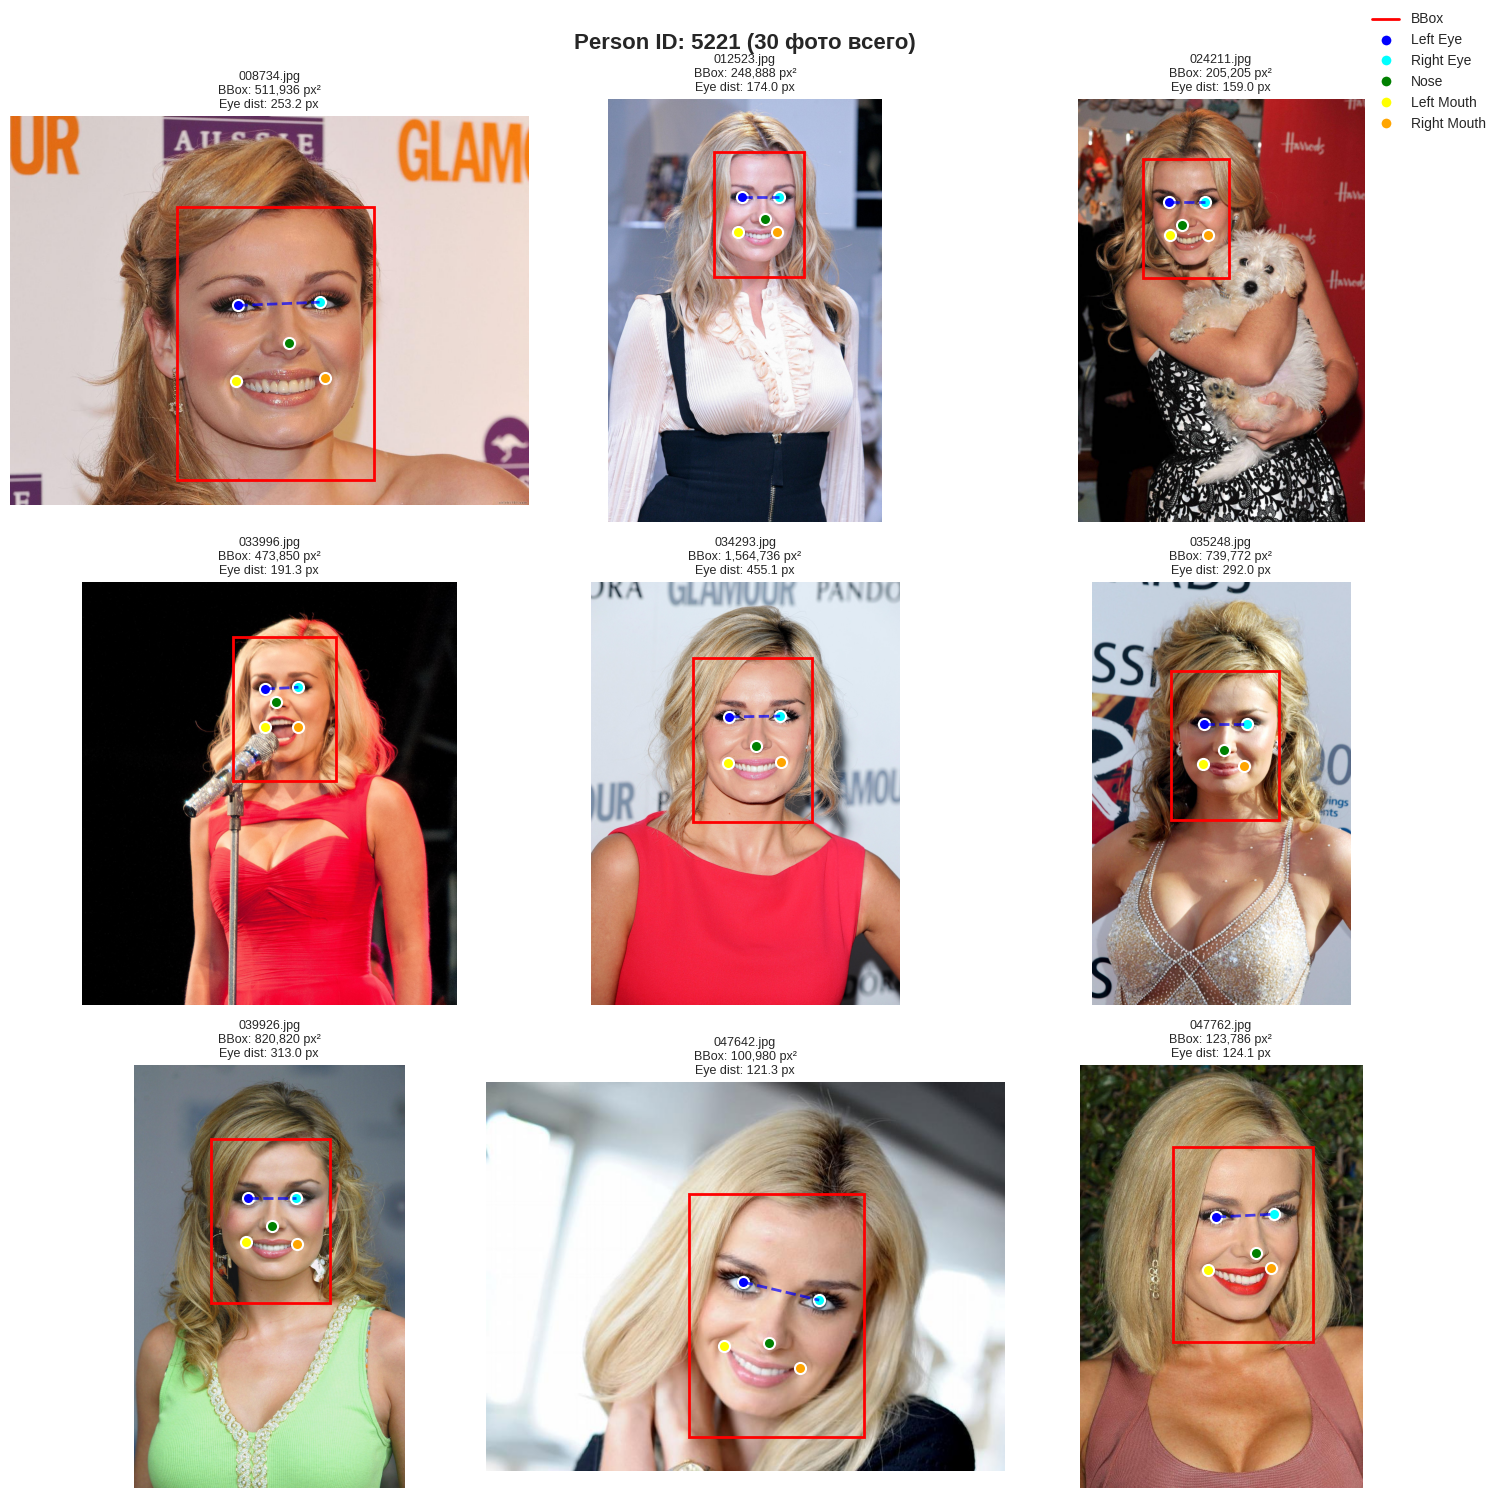

In [64]:
visualize_person(n_images=9)

## Фильтрация данных
Нужно выбрать какие фотографии попадут в результирующий датасет (примерно 10000) и обосновать почему. Как результат сохранить его отдельно.

Отбор проходит в несколько этапов:
1. Фильтрация по качеству (обязательное условие)
- Исключаем размытые изображения (Blurry = 1)
- Исключаем изображения с площадью bbox вне диапазона [BBOX_AREA_MIN, BBOX_AREA_MAX]
- Исключаем изображения с расстоянием между глазами вне диапазона [EYE_DIST_MIN, EYE_DIST_MAX]

2. Отбор персон по количеству фото
- Выбираем только персон с 20-35 качественными фотографиями
- Это гарантирует достаточно данных для обучения модели распознавать каждого человека
- Исключаем персон с < 20 фото (недостаточно примеров)
- Ограничиваем персон с > 35 фото (предотвращаем дисбаланс)

3. Ранжирование персон по разнообразию (Diversity Score)
- Для каждой персоны вычисляем diversity score (насколько разнообразны её фотографии)
- Разнообразие оценивается по ключевым атрибутам: пол, возраст, улыбка, очки, макияж, цвет волос и т.д.
- Персона получает больше баллов, если у неё есть фото И с атрибутом И без него
- Выбираем ~400 персон с наивысшим diversity score

4. Отбор разнообразных изображений для каждой персоны
- От каждой персоны берем по 25 фотографий
- Группируем фотографии персоны по уникальным комбинациям атрибутов
- Берем примерно поровну из каждой группы
- Это максимизирует разнообразие выражений лица, поз, освещения, аксессуаров

5. Проверка баланса атрибутов
- Проверяем что итоговый датасет сбалансирован по полу, возрасту и другим важным атрибутам
- Стремимся к балансу ~40-45% мужчин, ~55-60% женщин
- Сохраняем редкие атрибуты (очки ~5-10%, шляпы ~3-8%)

In [50]:
# Используем границы, установленные из анализа распределений
# BBOX_AREA_MIN, BBOX_AREA_MAX, EYE_DIST_MIN, EYE_DIST_MAX

# Объединяем необходимые данные по индексу
quality_data = df_attr[['Blurry']].join(df_bbox[['area']], how='inner')
quality_data = quality_data.join(df_landmarks[['eye_distance']], how='inner')


# Создаем маски для фильтрации
mask_not_blurry = quality_data['Blurry'] == 0
mask_bbox_ok = (quality_data['area'] >= BBOX_AREA_MIN) & (quality_data['area'] <= BBOX_AREA_MAX)
mask_eyes_ok = (quality_data['eye_distance'] >= EYE_DIST_MIN) & (quality_data['eye_distance'] <= EYE_DIST_MAX)

# Комбинируем все условия
quality_mask = mask_not_blurry & mask_bbox_ok & mask_eyes_ok
quality_images = quality_data[quality_mask].index

# Фильтруем все датафреймы
df_identity_filtered = df_identity[df_identity.index.isin(quality_images)]
df_attr_filtered = df_attr[df_attr.index.isin(quality_images)]
df_bbox_filtered = df_bbox[df_bbox.index.isin(quality_images)]
df_landmarks_filtered = df_landmarks[df_landmarks.index.isin(quality_images)]

print(f"Исходное количество: {len(quality_data):,}")
print(f"После фильтрации по качеству: {len(quality_images):,}")

Исходное количество: 202,598
После фильтрации по качеству: 173,996


In [51]:
MIN_PHOTOS_PER_PERSON = 20
MAX_PHOTOS_PER_PERSON = 35

# Подсчитываем фото для каждой персоны после фильтрации качества
person_counts_filtered = df_identity_filtered['person_id'].value_counts()

# Фильтруем персон
valid_persons = person_counts_filtered[
    (person_counts_filtered >= MIN_PHOTOS_PER_PERSON) & 
    (person_counts_filtered <= MAX_PHOTOS_PER_PERSON)
].index.tolist()

# Оставляем только валидных персон
df_identity_valid = df_identity_filtered[df_identity_filtered['person_id'].isin(valid_persons)]
print(f"Всего изображений у валидных персон: {len(df_identity_valid):,}")

Всего изображений у валидных персон: 117,958


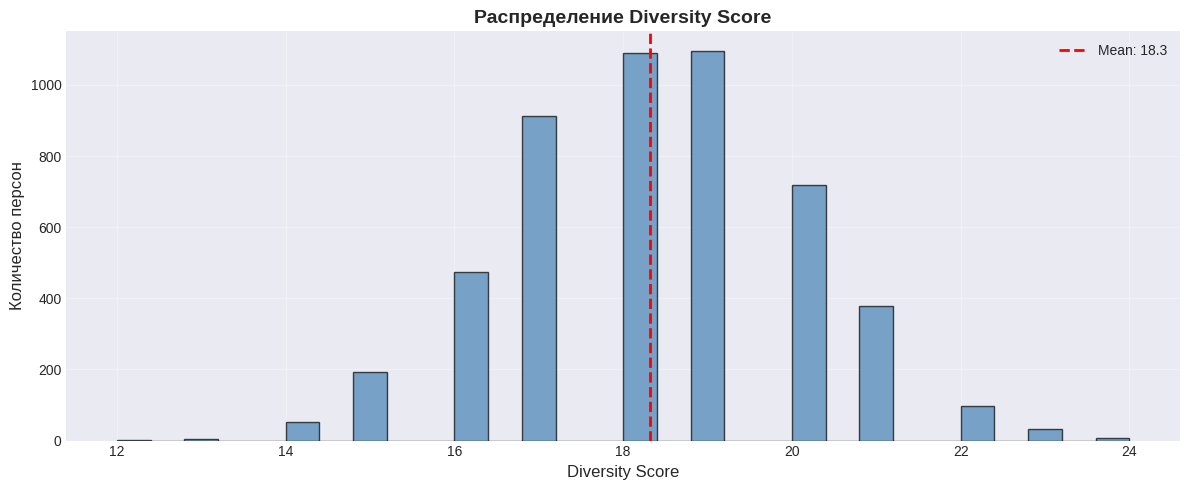

In [52]:
# Ключевые атрибуты для оценки разнообразия
KEY_ATTRIBUTES = [
    'Male', 'Young', 'Smiling', 'Eyeglasses', 
    'Heavy_Makeup', 'Wearing_Hat', 'Attractive',
    'Black_Hair', 'Blond_Hair', 'Brown_Hair',
    'Mouth_Slightly_Open', 'Wearing_Lipstick'
]

person_diversity = []

for person_id in valid_persons:
    person_images = df_identity_valid[df_identity_valid['person_id'] == person_id].index
    person_attrs = df_attr_filtered.loc[person_images, KEY_ATTRIBUTES]
    
    diversity_score = 0
    
    # Для каждого атрибута проверяем есть ли разнообразие
    for attr in KEY_ATTRIBUTES:
        has_attr = person_attrs[attr].sum() > 0
        hasnt_attr = (person_attrs[attr] == 0).sum() > 0
        
        if has_attr and hasnt_attr:
            diversity_score += 2  # Максимальное разнообразие
        elif has_attr or hasnt_attr:
            diversity_score += 1
    
    person_diversity.append({
        'person_id': person_id,
        'num_photos': len(person_images),
        'diversity_score': diversity_score
    })

df_diversity = pd.DataFrame(person_diversity)
df_diversity = df_diversity.sort_values('diversity_score', ascending=False)

# Визуализация распределения diversity score
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df_diversity['diversity_score'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Diversity Score', fontsize=12)
ax.set_ylabel('Количество персон', fontsize=12)
ax.set_title('Распределение Diversity Score', fontsize=14, fontweight='bold')
ax.axvline(df_diversity['diversity_score'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {df_diversity["diversity_score"].mean():.1f}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [53]:
TARGET_IMAGES = 10000
TARGET_MALE_RATIO = 0.42  # Целевая доля мужчин (близко к исходному датасету пытаемся её сохранить)
# Если добавлять персон только по diversity_score в датасет будет перекошен в сторону женщин (проверено имперически)

def select_diverse_images(person_images, n_select):
    """Выбирает максимально разнообразные изображения для персоны"""
    if len(person_images) <= n_select:
        return person_images
    
    person_attrs = df_attr_filtered.loc[person_images, KEY_ATTRIBUTES]
    person_attrs['signature'] = person_attrs.apply(lambda x: ''.join(x.astype(str)), axis=1)
    
    groups = person_attrs.groupby('signature')
    n_groups = len(groups)
    per_group = max(1, n_select // n_groups)
    
    selected = []
    remaining = n_select
    
    for signature, group in groups:
        n_take = min(per_group, remaining, len(group))
        if n_take > 0:
            selected.extend(group.sample(n=n_take, random_state=42).index.tolist())
            remaining -= n_take
    
    if remaining > 0:
        available = list(set(person_images) - set(selected))
        if available:
            additional = pd.Index(available).to_series().sample(
                n=min(remaining, len(available)), random_state=42
            ).tolist()
            selected.extend(additional)
    
    return selected[:n_select]


# Определяем пол для каждой персоны и добавляем в df_diversity
def get_person_gender(person_id):
    """Возвращает пол персоны на основе большинства её фото"""
    person_images = df_identity_valid[df_identity_valid['person_id'] == person_id].index
    male_count = df_attr_filtered.loc[person_images, 'Male'].sum()
    return 'Male' if male_count > len(person_images) / 2 else 'Female'

df_diversity['gender'] = df_diversity['person_id'].apply(get_person_gender)

# Разделяем по полу и сортируем по diversity score
male_persons = df_diversity[df_diversity['gender'] == 'Male'].sort_values('diversity_score', ascending=False)
female_persons = df_diversity[df_diversity['gender'] == 'Female'].sort_values('diversity_score', ascending=False)

# Отбор с балансировкой
selected_images = []
selected_persons = []
male_images = []
female_images = []

male_idx = 0
female_idx = 0

while len(selected_images) < TARGET_IMAGES:
    current_male_ratio = len(male_images) / len(selected_images) if len(selected_images) > 0 else 0
    
    # Выбираем мужчину или женщину в зависимости от текущего баланса
    if current_male_ratio < TARGET_MALE_RATIO and male_idx < len(male_persons):
        person_row = male_persons.iloc[male_idx]
        gender = 'Male'
        male_idx += 1
    elif female_idx < len(female_persons):
        person_row = female_persons.iloc[female_idx]
        gender = 'Female'
        female_idx += 1
    elif male_idx < len(male_persons):
        person_row = male_persons.iloc[male_idx]
        gender = 'Male'
        male_idx += 1
    else:
        break
    
    person_id = person_row['person_id']
    num_photos = person_row['num_photos']
    
    # Получаем все фото персоны
    person_images = df_identity_valid[df_identity_valid['person_id'] == person_id].index.tolist()
    
    # Отбираем разнообразные фото
    selected = select_diverse_images(person_images, num_photos)
    
    selected_images.extend(selected)
    selected_persons.append(person_id)
    
    if gender == 'Male':
        male_images.extend(selected)
    else:
        female_images.extend(selected)

print(f"✓ Выбрано персон: {len(selected_persons):,}")
print(f"  Мужчины:  {male_idx:,} персон")
print(f"  Женщины:  {female_idx:,} персон")
print(f"\n✓ Отобрано изображений: {len(selected_images):,}")
print(f"  Мужчины:  {len(male_images):,} ({len(male_images)/len(selected_images)*100:.1f}%)")
print(f"  Женщины:  {len(female_images):,} ({len(female_images)/len(selected_images)*100:.1f}%)")
print(f"  Среднее фото на персону: {len(selected_images) / len(selected_persons):.1f}")

✓ Выбрано персон: 409
  Мужчины:  173 персон
  Женщины:  236 персон

✓ Отобрано изображений: 10,013
  Мужчины:  4,204 (42.0%)
  Женщины:  5,809 (58.0%)
  Среднее фото на персону: 24.5


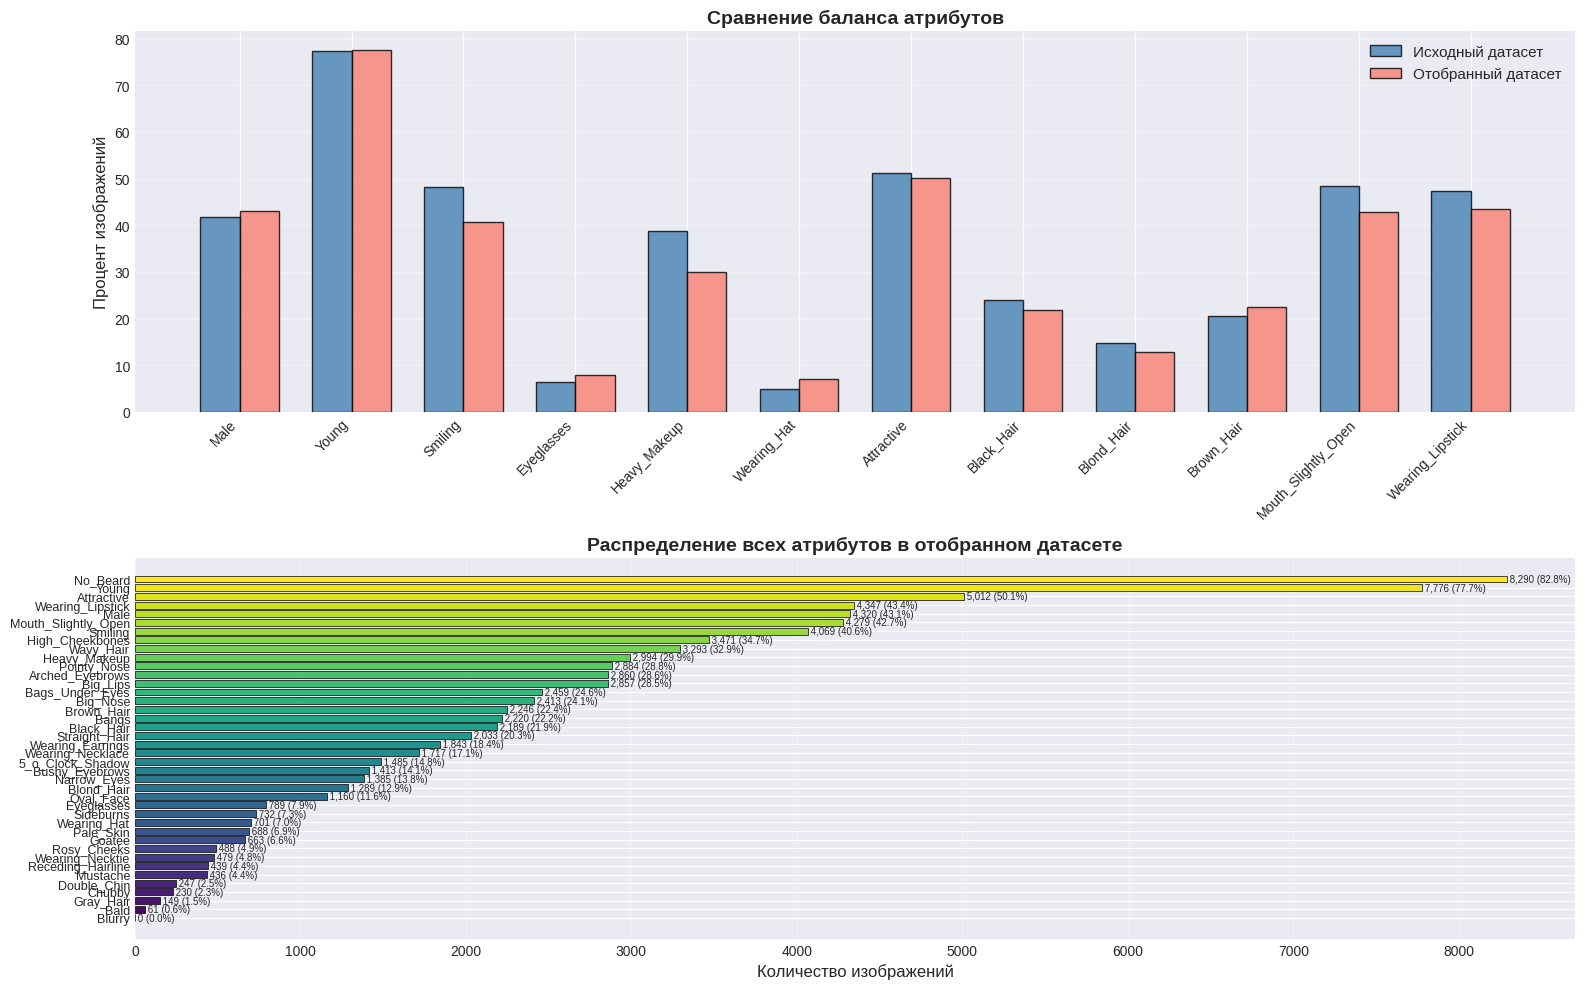

In [54]:
# Финальный поднабор
df_subset_attr = df_attr_filtered.loc[selected_images]

# Сравнение с исходным датасетом
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# График 1: Сравнение распределения ключевых атрибутов
comparison_data = []
for attr in KEY_ATTRIBUTES:
    original_pct = (df_attr[attr].sum() / len(df_attr)) * 100
    subset_pct = (df_subset_attr[attr].sum() / len(df_subset_attr)) * 100
    comparison_data.append({
        'Атрибут': attr,
        'Исходный': original_pct,
        'Отобранный': subset_pct
    })

df_comparison = pd.DataFrame(comparison_data)

x = np.arange(len(KEY_ATTRIBUTES))
width = 0.35

axes[0].bar(x - width/2, df_comparison['Исходный'], width, label='Исходный датасет', 
           alpha=0.8, edgecolor='black', color='steelblue')
axes[0].bar(x + width/2, df_comparison['Отобранный'], width, label='Отобранный датасет', 
           alpha=0.8, edgecolor='black', color='salmon')

axes[0].set_ylabel('Процент изображений', fontsize=12)
axes[0].set_title('Сравнение баланса атрибутов', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(KEY_ATTRIBUTES, rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# График 2: Распределение всех атрибутов в отобранном датасете
all_attrs = [col for col in df_attr.columns]
attr_counts = df_subset_attr[all_attrs].sum().sort_values(ascending=True)

colors = plt.cm.viridis(np.linspace(0, 1, len(attr_counts)))
axes[1].barh(range(len(attr_counts)), attr_counts.values, color=colors, 
            edgecolor='black', linewidth=0.5)
axes[1].set_yticks(range(len(attr_counts)))
axes[1].set_yticklabels(attr_counts.index, fontsize=9)
axes[1].set_xlabel('Количество изображений', fontsize=12)
axes[1].set_title('Распределение всех атрибутов в отобранном датасете', 
                 fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

for i, (attr, count) in enumerate(attr_counts.items()):
    pct = (count / len(df_subset_attr)) * 100
    axes[1].text(count, i, f' {count:,} ({pct:.1f}%)', va='center', fontsize=7)

plt.tight_layout()
plt.show()

In [55]:
output_base = Path('/kaggle/working/celeba_subset_10k')
output_images = output_base / 'images'
output_annotations = output_base / 'annotations'

# Удаляем старую версию если существует
if output_base.exists():
    shutil.rmtree(output_base)

output_base.mkdir(exist_ok=True)
output_images.mkdir(exist_ok=True)
output_annotations.mkdir(exist_ok=True)

In [56]:
print(f"\nКопирование {len(selected_images):,} изображений...")

copied_count = 0
failed_count = 0
failed_images = []

for img_id in selected_images:
    src = Path(IMAGES_DIR) / img_id
    dst = output_images / img_id
    
    if src.exists():
        try:
            shutil.copy2(src, dst)
            copied_count += 1
        except Exception as e:
            failed_count += 1
            failed_images.append(img_id)
    else:
        failed_count += 1
        failed_images.append(img_id)

print(f"\n✓ Успешно скопировано: {copied_count:,} изображений")
if failed_count > 0:
    print(f"⚠ Не удалось скопировать: {failed_count:,} изображений")
    if failed_count <= 10:
        print(f"  Список: {failed_images}")



Копирование 10,013 изображений...

✓ Успешно скопировано: 10,013 изображений


In [57]:
with open(output_annotations / 'identity_CelebA.txt', 'w') as f:
    for img_id in selected_images:
        if img_id in df_identity_filtered.index:
            person_id = df_identity_filtered.loc[img_id, 'person_id']
            f.write(f"{img_id} {person_id}\n")
print(f"Добавлено identity_CelebA.txt ({len(selected_images):,} записей) в резульирующий dataset")

Добавлено identity_CelebA.txt (10,013 записей) в резульирующий dataset


In [58]:
with open(output_annotations / 'list_attr_celeba.txt', 'w') as f:
    # Первая строка - количество изображений
    f.write(f"{len(selected_images)}\n")
    # Вторая строка - названия атрибутов
    attr_names = ' '.join(df_attr_filtered.columns)
    f.write(f"{attr_names}\n")
    # Данные
    for img_id in selected_images:
        if img_id in df_attr_filtered.index:
            attrs = df_attr_filtered.loc[img_id]
            # Конвертируем обратно в -1/1 (как в оригинальном формате)
            attr_values = ' '.join([str(1 if v == 1 else -1) for v in attrs])
            f.write(f"{img_id} {attr_values}\n")
print(f"Добавлено list_attr_celeba.txt ({len(selected_images):,} записей, {len(df_attr_filtered.columns)} атрибутов)  в резульирующий dataset")

Добавлено list_attr_celeba.txt (10,013 записей, 40 атрибутов)  в резульирующий dataset


In [59]:
with open(output_annotations / 'list_bbox_celeba.txt', 'w') as f:
    f.write(f"{len(selected_images)}\n")
    f.write("image_id x_1 y_1 width height\n")
    for img_id in selected_images:
        if img_id in df_bbox_filtered.index:
            bbox = df_bbox_filtered.loc[img_id]
            f.write(f"{img_id} {int(bbox['x_1'])} {int(bbox['y_1'])} {int(bbox['width'])} {int(bbox['height'])}\n")
print(f"Добавлено list_bbox_celeba.txt ({len(selected_images):,} записей)  в резульирующий dataset")

Добавлено list_bbox_celeba.txt (10,013 записей)  в резульирующий dataset


In [60]:
with open(output_annotations / 'list_landmarks_celeba.txt', 'w') as f:
    f.write(f"{len(selected_images)}\n")
    f.write("lefteye_x lefteye_y righteye_x righteye_y nose_x nose_y leftmouth_x leftmouth_y rightmouth_x rightmouth_y\n")
    for img_id in selected_images:
        if img_id in df_landmarks_filtered.index:
            lm = df_landmarks_filtered.loc[img_id]
            f.write(f"{img_id} {int(lm['lefteye_x'])} {int(lm['lefteye_y'])} {int(lm['righteye_x'])} {int(lm['righteye_y'])} ")
            f.write(f"{int(lm['nose_x'])} {int(lm['nose_y'])} {int(lm['leftmouth_x'])} {int(lm['leftmouth_y'])} ")
            f.write(f"{int(lm['rightmouth_x'])} {int(lm['rightmouth_y'])}\n")
print(f"Добавлено list_landmarks_celeba.txt ({len(selected_images):,} записей)  в резульирующий dataset")

Добавлено list_landmarks_celeba.txt (10,013 записей)  в резульирующий dataset


In [61]:
zip_path = Path('/kaggle/working/celeba_subset_10k.zip')

# Удаляем старый архив если есть
if zip_path.exists():
    zip_path.unlink()

print(f"\nСоздание архива...")

files_added = 0
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED, compresslevel=6) as zipf:
    for file_path in output_base.rglob('*'):
        if file_path.is_file():
            arcname = file_path.relative_to(output_base.parent)
            zipf.write(file_path, arcname)
            files_added += 1

print(f"\n✓ ZIP-архив создан: {zip_path}")
print(f"  Всего файлов в архиве: {files_added:,}")
print(f"  Размер архива: {zip_path.stat().st_size / (1024**2):.1f} MB")


Создание архива...

✓ ZIP-архив создан: /kaggle/working/celeba_subset_10k.zip
  Всего файлов в архиве: 10,017
  Размер архива: 360.6 MB
